# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LogisticRegression

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
cases = pd.read_csv('Data.nosync/Similar_TM.csv')
cases.sample(20)

,TM_A,TM_B,target
71,Eden Pure,Eden Aesthetics,1
2,Zirco,Cozirc,1
303,CME,IRSIA CMF,0
335,GSR,GSRD,0
126,Healthy Times,TIME HEALTH,1
28,Fashion two twenty,Fashion tan,1
309,MCQ,UKMQ,0
128,DIALux,DIAL,1
257,TIAMA,TIANA,1
245,ANNAS,AMMA,1


In [3]:
import unidecode
from fuzzywuzzy import fuzz
import jellyfish

from abydos.distance import (IterativeSubString, BISIM, DiscountedLevenshtein, Prefix, LCSstr, MLIPNS, Strcmp95,
MRA, Editex, SAPS, FlexMetric, JaroWinkler, HigueraMico, Sift4, Eudex, ALINE, PhoneticEditDistance)

from abydos.phonetic import PSHPSoundexFirst, Ainsworth
pshp_soundex_first = PSHPSoundexFirst()
pe = Ainsworth()

In [4]:
iss = IterativeSubString()
bisim = BISIM()
dlev = DiscountedLevenshtein()
prefix = Prefix()
lcs = LCSstr()
mlipns = MLIPNS()
strcmp95 = Strcmp95()
mra = MRA()
editex = Editex()
saps = SAPS()
flexmetric = FlexMetric()
jaro = JaroWinkler(mode='Jaro')
higuera_mico = HigueraMico()
sift4 = Sift4()
eudex = Eudex()
aline = ALINE()
phonetic_edit = PhoneticEditDistance()

In [5]:
algos = [iss, bisim, dlev, prefix, lcs, mlipns, strcmp95, mra, editex, saps, flexmetric, jaro, higuera_mico, sift4, eudex,
         aline, phonetic_edit]

algo_names = ['iterativesubstring', 'bisim', 'discountedlevenshtein', 'prefix', 'lcsstr', 'mlipns', 'strcmp95', 'mra',
              'editex', 'saps', 'flexmetric', 'jaro', 'higueramico', 'sift4', 'eudex', 'aline',
              'phoneticeditdistance']

In [6]:
from abydos.phones import *

In [7]:
def sum_ipa(name_a, name_b):
    feat1 = ipa_to_features(pe.encode(name_a))
    feat2 = ipa_to_features(pe.encode(name_b))
    if len(feat1) <= 1:
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/1
    else:    
        score = sum(cmp_features(f1, f2) for f1, f2 in zip(feat1, feat2))/len(feat1)
    return score

In [8]:
import re

In [9]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

def featurize(df):
    if len(df.columns)==3:
        df.columns=['a', 'b', 'target']
    elif len(df.columns)==2:
        df.columns=['a', 'b']
    else:
        df = df.rename(columns={df.columns[0]: 'a', df.columns[1]: 'b' })
        
    df['TM_A'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['a']).lower()), axis=1)
    df['TM_B'] = df.apply(lambda row: re.sub(
        '[^a-zA-Z]+', '', unidecode.unidecode(row['b']).lower()), axis=1)
    

    df['partial'] = df.apply(lambda row: fuzz.partial_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_sort'] = df.apply(lambda row: fuzz.token_sort_ratio(row.TM_A,row.TM_B), axis=1)
    df['tkn_set'] = df.apply(lambda row: fuzz.token_set_ratio(row.TM_A,row.TM_B), axis=1)
    
    df['sum_ipa'] = df.apply(lambda row: sum_ipa(row.TM_A,row.TM_B), axis=1)
    
    # Jellyfish levenshtein
    df['levenshtein']= df.apply(lambda row: jellyfish.levenshtein_distance(row.TM_A,row.TM_B), axis=1)
    # Scale Levenshtein column
    scaler = MinMaxScaler()
    df['levenshtein'] = scaler.fit_transform(df['levenshtein'].values.reshape(-1,1))

    # Jellyfish phoneme
    df['metaphone'] = df.apply(
        lambda row: 1 if jellyfish.metaphone(row.TM_A)==jellyfish.metaphone(row.TM_B) else 0, axis=1)
    df['nysiis'] = df.apply(
        lambda row: 1 if jellyfish.nysiis(row.TM_A)==jellyfish.nysiis(row.TM_B) else 0, axis=1)
    df['mtch_rtng_cdx'] = df.apply(
        lambda row: 1 if jellyfish.match_rating_codex(row.TM_A)==jellyfish.match_rating_codex(row.TM_B) else 0, axis=1)
    
    df['pshp_soundex_first'] = df.apply(
        lambda row: 1 if pshp_soundex_first.encode(row.TM_A)==pshp_soundex_first.encode(row.TM_B) else 0, axis=1)
    
    for i, algo in enumerate(algos):
            df[algo_names[i]] = df.progress_apply(lambda row: algo.sim(row.TM_A, row.TM_B), axis=1)

    
    return df

In [10]:
# featurize(cases)

### Class Balancing  
We can see that the classes are imbalanced, there are more instances of trademark invalidation than are dismissals.

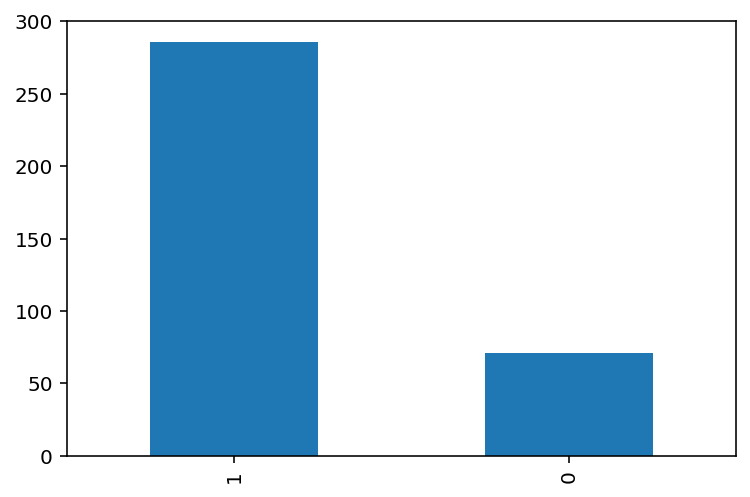

In [11]:
cases['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Unbalanced.png', dpi = 300)

In [12]:
from itertools import combinations
import random
random.seed(42)


In [13]:
# Use combinatorics to generate negative class
pos_cases = cases[cases['target'] == 1]

case_names = pos_cases.loc[:, 'TM_A':'TM_B'].values.tolist()
unique_cases = list(set([item for items in case_names for item in items]))
alt_pairs = list(zip(pos_cases.TM_A, pos_cases.TM_B))+ list(zip(pos_cases.TM_B, pos_cases.TM_A))
comb = list(combinations(unique_cases, 2))
nonmatch_cases = list(set(comb) - set(alt_pairs))
# Undersample the negative class for 1:4 class imbalance instead of 1:1000 extreme class imbalance
nonmatch_cases = pd.DataFrame(random.choices(nonmatch_cases, k=1200), columns=['TM_A', 'TM_B']) # Originally was 1200

nonmatch_cases

,TM_A,TM_B
0,UBS SMARTWEALTH,LEPICOL
1,NeverWeather,SILENT POOL
2,SOUPEDUP AND JUICED,Oakky
3,DIXIE UNION,VERVE
4,CANDEY,ADDICTION
...,...,...
1195,SAVVY,UBS SMARTWEALTH
1196,AEG,TOMMY
1197,ITP,+ Class View
1198,DIAL,EDOMIGE


In [14]:
print('positive class ratio 1:{}'.format(int(len(nonmatch_cases)/len(pos_cases))))

positive class ratio 1:4


In [15]:
nonmatch_cases.sample(20)

,TM_A,TM_B
836,Nivalin,UP&GO & OATS
527,Lumina,KOTO
107,Oakky,BOOBOO
174,HELLO DIET,KINKCENTRAL
1176,BEATRICE.B,K-9
42,SugarZERO,TREADSTONE
893,Seycos,Your Maternity Shop
156,DUNSTON,HiGeen
455,BLEND IT MILKSHAKES,IFIS
851,RED BULL,SEARCH SAVVY PR


In [16]:
# Negative Class
nonmatch_cases['target'] = 0
df = pd.concat([pos_cases, nonmatch_cases])
# non_match_cases = None
# pos_cases = None

# Add true negatives
neg_cases = cases[cases['target'] == 0]
class_balanced = pd.concat([df, neg_cases])

class_balanced.sample(20)

# class_balanced[class_balanced['TM_B'].str.len()!=0]


,TM_A,TM_B,target
104,CONNECT.COM,CONNECT AUTO,1
671,F.A.B. Method,WINSTON,0
1117,KERV,MULTIVAN,0
390,The LAD Bible,ADDICTION,0
569,ANNKE,Point,0
372,SABIS,WOODLAND,0
112,Nivalin,Novalin,1
316,ADVANTAGE HOLIDAYS BY ADVANTAGE,UWELL,0
154,Magnavoc,GENIE,0
303,Red Panda,TIANA,0


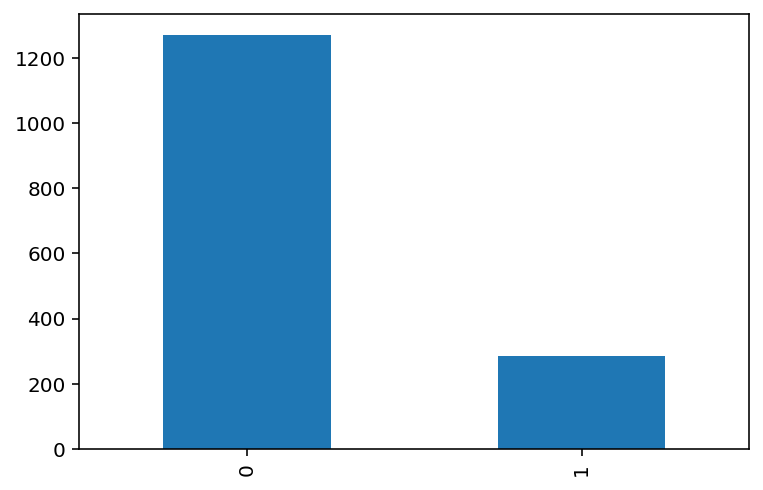

In [17]:
class_balanced['target'].value_counts()[:2].plot(kind='bar')

# plt.savefig('TM_Balanced.png', dpi = 300)

In [18]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

df = featurize(class_balanced)
df.sample(20)

<ipython-input-18-213a59b7ad7e>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/seannguyen/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,a,b,target,TM_A,TM_B,partial,tkn_sort,tkn_set,sum_ipa,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,bisim,discountedlevenshtein,prefix,lcsstr,mlipns,strcmp95,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
627,PURE IPR,LIFESTYLE,0,pureipr,lifestyle,14,12,12,0.592166,0.222222,0,0,0,0,0.000000,0.111111,0.113592,0.000000,0.111111,0.0,0.361376,0.000000,0.222222,0.000000,0.288889,0.335979,0.097222,0.111111,0.585784,0.274468,0.614695
1127,Lumina,ITP,0,lumina,itp,33,22,22,0.322581,0.138889,0,0,0,0,0.000000,0.166667,0.203911,0.000000,0.166667,0.0,0.000000,0.000000,0.166667,0.000000,0.183333,0.000000,0.050000,0.166667,0.792647,0.200000,0.422043
82,DIXY CHICKEN,Trucool,0,dixychicken,trucool,14,11,11,0.413490,0.277778,0,0,0,0,0.000000,0.090909,0.115776,0.000000,0.090909,0.0,0.481385,0.000000,0.318182,0.000000,0.409091,0.411255,0.027525,0.090909,0.842157,0.180328,0.570381
1197,ITP,+ Class View,0,itp,classview,33,17,17,0.682796,0.222222,0,0,0,0,0.000000,0.111111,0.151813,0.000000,0.111111,0.0,0.000000,0.000000,0.277778,0.000000,0.300000,0.000000,0.000000,0.000000,0.537255,0.197872,0.301075
749,GAZIANTEPLILER PASTANESI,Karex,0,gazianteplilerpastanesi,karex,40,21,21,0.148668,0.555556,0,0,0,0,0.000000,0.086957,0.145664,0.000000,0.043478,0.0,0.544348,0.000000,0.173913,0.000000,0.234783,0.495652,0.000000,0.086957,0.862255,0.120661,0.206872
391,Galaxy Print Finishing,SABIS,0,galaxyprintfinishing,sabis,40,24,24,0.203226,0.472222,0,0,0,0,0.000000,0.125000,0.170936,0.000000,0.100000,0.0,0.525000,0.000000,0.200000,0.000000,0.265000,0.500000,0.000000,0.050000,0.762255,0.183036,0.240323
56,SYNDIKAT,SIMTEC,0,syndikat,simtec,33,43,43,0.721774,0.194444,0,0,0,1,0.050000,0.312500,0.185192,0.166667,0.125000,0.0,0.615278,0.000000,0.437500,0.000000,0.550000,0.527778,0.209921,0.375000,0.900980,0.575000,0.713710
155,PACIFICO,The Oxford Centre for Christian Apologetics,0,pacifico,theoxfordcentreforchristianapologetics,38,17,17,0.745968,0.944444,0,0,0,0,0.000000,0.092105,0.119707,0.000000,0.052632,0.0,0.497588,0.000000,0.210526,0.000000,0.311842,0.452193,0.000000,0.052632,0.654902,0.113333,0.199491
1030,BIOBUSTER,Eden Aesthetics,0,biobuster,edenaesthetics,33,26,26,0.706093,0.305556,0,0,0,0,0.000000,0.178571,0.184989,0.000000,0.142857,0.0,0.459524,0.000000,0.321429,0.000000,0.442857,0.404762,0.148834,0.214286,0.456863,0.352703,0.555300
238,Tailor-Tee,IQOS,0,tailortee,iqos,50,31,31,0.385305,0.194444,0,0,0,0,0.000000,0.222222,0.255086,0.000000,0.111111,0.0,0.574074,0.000000,0.333333,0.000000,0.522222,0.574074,0.032143,0.222222,0.599020,0.139535,0.399642


#### Export clean data to csv

In [ ]:
# df.to_csv('Data.nosync/TM_features.csv', index=False)  

In [20]:
y = df.target
X = df.drop(columns = 'target')

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
#X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1)

## TPOT AutoML pipeline

In [ ]:
from tpot import TPOTClassifier

In [ ]:
# pipeline_optimizer = TPOTClassifier(
#         scoring = 'f1', 
#         generations=100,
#         verbosity=2,
#         n_jobs=-1   # Utilizes all available CPU cores
#         ) 
# pipeline_optimizer.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), y_train)

In [ ]:
# print(pipeline_optimizer.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test))

### Export TPOT pipeline

In [ ]:
# pipeline_optimizer.export('tpot_exported_calssifier_pipeline.py')

### Load TPOT pipeline

In [ ]:
df_TPOT = df.drop(columns = ['a','b','TM_A','TM_B'])
df_TPOT

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df_TPOT
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8945711361541637
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    GradientBoostingClassifier(learning_rate=0.01, max_depth=3, max_features=0.5,
                               min_samples_leaf=10, min_samples_split=3, 
                               n_estimators=100, subsample=0.9500000000000001)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

results

In [ ]:
def base_model_1(X_train, y_train, X_test, export = False) :
    exported_pipeline = make_pipeline(
    GradientBoostingClassifier(
        learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
    )

    exported_pipeline.fit(X_train, y_train)
    if export==True:
        return exported_pipeline
    else:
        y_pred = exported_pipeline.predict_proba(X_test)
        return [p[1] for p in y_pred]

In [ ]:
base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'],1), 
             y_train, X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# K-fold cross validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
pd.options.mode.chained_assignment = None

# Stratified K-Folds cross-validator
meta_training = pd.DataFrame()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

fold = 1
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    oof_pred = X_test[['TM_A', 'TM_B']]
    
    oof_pred['predict_proba'] = base_model_1(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1),
                                      y_train,
                                      X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
    
    oof_pred['target'] = y_test.tolist()
    
    print('completed fold {} of 10'.format(fold))
    fold += 1

    meta_training = meta_training.append(oof_pred)

In [ ]:
meta_training.sample(20)

### Meta-Model: Logistic Regression

In [ ]:
df=featurize(meta_training)

In [ ]:
df.sample(20)

### Evaluate Gradient Boosting Classifier

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

gb_clf2 = GradientBoostingClassifier(learning_rate=0.01, 
        max_depth=3, max_features=0.5,
        min_samples_leaf=10, min_samples_split=3, 
        n_estimators=100, subsample=0.9500000000000001)
gb_clf2.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)
predictions = gb_clf2.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

In [ ]:
predictions

In [ ]:
# df_confusion.to_csv('TM_GBC_Confusion_matrix.csv')

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = gb_clf2.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('TM_GBC_ROC.png', dpi = 300)

In [ ]:
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot = True,
            cmap="YlGnBu_r")
heat_map=plt.gcf()
heat_map.set_size_inches(20,15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# XGboost

In [ ]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

y = df.target
X = df.drop(columns = ['target','predict_proba'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
D_train = xgb.DMatrix(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_train)
D_test = xgb.DMatrix(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3}

steps = 20  # The number of training iterations

xgbmodel = xgb.train(param, D_train, steps)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = xgbmodel.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=10)

grid.fit(X_train.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_train)

In [ ]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
# pickle.dump(grid.best_estimator_, open("Data.nosync/TM_XGboost_classifier.pkl", "wb"))

### Test saved model

In [23]:
import pickle
import numpy as np

# load the model from disk
loaded_model = pickle.load(open("Data.nosync/TM_XGboost_classifier.pkl", 'rb'))
result = loaded_model.score(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y_test)
print(result)

0.9519230769230769


In [26]:
proba_result = loaded_model.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

paa = [p[1] for p in proba_result]

paa




[0.66269153,
 0.8952138,
 0.0062926686,
 0.005451213,
 0.005086109,
 0.6184402,
 0.6965233,
 0.006455301,
 0.005086109,
 0.073286995,
 0.8925104,
 0.0176966,
 0.005086109,
 0.7895966,
 0.005588669,
 0.016065467,
 0.005248141,
 0.005086109,
 0.7486737,
 0.023591796,
 0.3498808,
 0.017419038,
 0.005248141,
 0.007751674,
 0.91489357,
 0.006934082,
 0.85752624,
 0.91340494,
 0.83272535,
 0.005086109,
 0.0052247136,
 0.91905504,
 0.005086109,
 0.0072437595,
 0.016220106,
 0.005086109,
 0.7622635,
 0.005086109,
 0.010455422,
 0.013005878,
 0.8270256,
 0.44341785,
 0.005086109,
 0.0062463186,
 0.0060976255,
 0.005086109,
 0.8655519,
 0.0055997116,
 0.006314867,
 0.005086109,
 0.007331088,
 0.005086109,
 0.8046192,
 0.0060670525,
 0.023354523,
 0.035249777,
 0.36473787,
 0.006000083,
 0.005248141,
 0.00666589,
 0.005086109,
 0.005086109,
 0.8959903,
 0.005248141,
 0.0052247136,
 0.55314326,
 0.0060670525,
 0.8250887,
 0.005086109,
 0.008535243,
 0.005086109,
 0.005086109,
 0.005086109,
 0.0063

In [27]:
loaded_model.predict(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,

In [31]:
# Import pandas library 
import pandas as pd 
  
# initialize list of lists 
data = [['Flipn Chicken','Frickn Chicken']] 
  
# Create the pandas DataFrame 
mydf = pd.DataFrame(data, columns = ['bboyaa', 'fdslkajsdf']) 
  
# print dataframe. 
mydf 

,bboyaa,fdslkajsdf
0,Flipn Chicken,Frickn Chicken


In [32]:
featurize(mydf)

,a,b,TM_A,TM_B,partial,tkn_sort,tkn_set,sum_ipa,levenshtein,metaphone,nysiis,mtch_rtng_cdx,pshp_soundex_first,iterativesubstring,bisim,discountedlevenshtein,prefix,lcsstr,mlipns,strcmp95,mra,editex,saps,flexmetric,jaro,higueramico,sift4,eudex,aline,phoneticeditdistance
0,Flipn Chicken,Frickn Chicken,flipnchicken,fricknchicken,75,80,80,0.972141,0.0,0,0,0,0,0.761313,0.769231,0.715296,0.083333,0.615385,0.0,0.805192,0.666667,0.846154,0.604167,0.815385,0.767521,0.769231,0.769231,0.919608,0.812658,0.899504


In [33]:
foo = featurize(mydf)
foo2 = foo.drop(['a', 'b', 'TM_A', 'TM_B'], 1)

foo3 = loaded_model.predict_proba(foo2)

foo4 = [p[1] for p in foo3]

foo4

[0.9122305]

In [34]:
def XGboost_ratio(data):
    df = featurize(data)
    df2 = df.drop(['a', 'b', 'TM_A', 'TM_B'], 1)
    df3 = loaded_model.predict_proba(df2)
    df4 = [p[1] for p in df3]
    return df4

In [36]:
XGboost_ratio(mydf)

[0.9122305]

In [38]:
pd = pd.read_csv("Data.nosync/TM_clean_soundex.csv", index_col = False)

# df_matches = df[df.apply(get_ratio, axis = 1) > 70]

pd['wordmark']

0                                                      daisy
1                                                  budweiser
2                                       washburns gold medal
3                                                      giant
4                                                    welcome
                                 ...                        
1071622                                                  etf
1071623                                              europol
1071624                                   parati vero parati
1071625    organisation africaine de la propriete intelle...
1071626                 the great seal of the choctaw nation
Name: wordmark, Length: 1071627, dtype: object

### Evaluate XGboost

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid.predict_proba(X_test.drop(['a', 'b', 'TM_A', 'TM_B'], 1))
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

# plt.savefig('Figs/TM_XGBoost_ROC.png', dpi = 600)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, best_preds))

print("Classification Report")
print(classification_report(y_test, best_preds))

In [ ]:
import joblib

xgbmodel.dump_model('Data.nosync/TM_XGBoost_model.pkl')

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

plot_importance(xgbmodel)
# pyplot.show()
# plt.savefig("Figs/TM_XGboost_feature_importance.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


shap.summary_plot(shap_values[0], X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), plot_type="bar", show=False)
# plt.savefig("Figs/TM_XGboost_SHAP_features.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("discountedlevenshtein", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


In [ ]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("iterativesubstring", shap_values[0],
                     X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))


In [ ]:
# summarize the effects of all the features
shap.summary_plot(shap_values[0],
                X.drop(['a', 'b', 'TM_A', 'TM_B'], 1))

# Grid Search   

Hyperparameter tuning

In [ ]:
cols = [col for col in df.columns if col not in ['a', 'b', 'TM_A', 'TM_B', 'target', 'predict_proba']]
comb2 = list(combinations(cols, 2))
comb3 = list(combinations(cols, 3))
colgrid = [(col,)for col in cols]+comb2+comb3


colgrid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring = 'precision', verbose=0)

scores = []
for cols in colgrid:
    grid_clf.fit(X_train[['predict_proba']+list(cols)], y_train)
    y_pred = grid_clf.predict(X_val[['predict_proba']+list(cols)])
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    scores.append([str(cols), tn, fp, fn, tp])

In [ ]:
scores_df = pd.DataFrame(scores)

In [ ]:
scores_df.columns = ['features', 'tn', 'fp', 'fn', 'tp']

In [ ]:
scores_df.head()

In [ ]:
scores_df['error'] = scores_df['fp'] + scores_df['fn']

In [ ]:
scores_df = scores_df.sort_values(['error', 'fp'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df.target, test_size=0.2, random_state=42)

In [ ]:
selected_cols = ['discountedlevenshtein', 'phoneticeditdistance', 'iterativesubstring', 'sum_ipa']

In [ ]:
clf = LogisticRegression()
grid_clf = GridSearchCV(clf, param_grid = {'C':np.logspace(-4, 4, 20)}, scoring='precision')
grid_clf.fit(X_train[selected_cols], y_train)
y_pred = grid_clf.predict(X_test[selected_cols])

In [ ]:
print(grid_clf.best_params_)

## Evaluation

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
    print(classification_report(y_test, y_pred))
    print(conf_matrix)

In [ ]:
evaluate(y_test, y_pred)

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
baseline_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
probs = grid_clf.predict_proba(X_test[selected_cols])
probs = probs[:, 1]

# calculate scores
baseline_auc = roc_auc_score(y_test, baseline_probs)
auc = roc_auc_score(y_test, probs)
auc = ('AUC=%.3f' % (auc))

# calculate roc curves
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
fpr, tpr, _ = roc_curve(y_test, probs)

# plot the roc curve for the model
ax.plot(baseline_fpr, baseline_tpr, color='gray')
ax.plot(fpr, tpr, marker='.', color='black')

# axis labels
ax.set_xlabel('False Positive Rate',fontsize=12)
ax.set_ylabel('True Positive Rate',fontsize=12)
ax.set_title('Receiver Operating Characteristic', fontsize=16)
plt.text(.6, .3, auc, fontsize=13)

### Export Models and Pipeline

In [ ]:
import joblib
import json

In [ ]:
base_1 = base_model_1(X.drop(['a', 'b', 'TM_A', 'TM_B'], 1), y, X_test=None, export=True)
joblib.dump(base_1, filename='Data.nosync/TM_Gradient_boost_base_model.pkl')

In [ ]:
# base_model_2(X[['name_a', 'name_b']], y, X_test=None, export=True)

In [ ]:
joblib.dump(grid_clf.best_estimator_, filename='Data.nosync/TM_meta_model.pkl')